# 3b. Evaluate group snapshots

In the last notebook, I showed how to prepare group snapshots using `patientflow`. Now, let's think about how to evaluate those models. The goal is to evaluate how well a predicted bed count distribution compares with the observed bed counts at each prediction time over the period of the test set. 

There are various approaches. Here I demonstrate two. 

### Mean Absolute Error and Mean Percentage Error

For each prediction moment, subtract the expected value from the predicted probability distribution from the observed number of admissions to get an error value for each prediction time. Over the whole test set, calculate the Mean Absolute Error (MAE), which avoids positive and negative deviations cancelling each other out. The error can also be expressed as a percentage of observed admissions to derive a mean percentage error (MPE). 

This is a common approach so it is worth showing. I also plot the difference between expected and observed, which is more revealing the calculating a single number, as it gives a sense of the spread of errors, and whether the model tends to over- or underestimate. 

### QQ Plots

Other methods appraise the performance of the model across the whole distribution. If a model predicts the tails of a distribution well, the observed number of beds would appear in the lowest tenth of the distribution on 10% of prediction moments, and likewise in the highest tenth on 10% of prediction moments. A Quantile-Quantile (QQ) Plot can be used to compare one probability distribution with another. The observed values across the test set are treated as a distribution, and compared with predicted distribution

### About the data used in this notebook

I'm going to use real patient data from visits to the Emergency Department (ED) at UCLH to demonstrate the evaluation. The methods shown will work on any data in the same structure. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.




## Loading real patient data

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
import pandas as pd
from patientflow.load import set_file_paths, load_data

# set project root
from patientflow.load import set_project_root
project_root = set_project_root()

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public', # change this to data-synthetic if you don't have the public dataset
        verbose=False) 

# load the data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date


Inferred project root: /Users/zellaking/Repos/patientflow


The dates for training, validation and test sets that match this dataset are defined in the config file in the root directory of `patientflow`.

In [3]:
#  load config file
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set = params["start_training_set"]
print(f"Training set starts: {start_training_set}")

start_validation_set = params["start_validation_set"]
print(f"Validation set starts: {start_validation_set}")

start_test_set = params["start_test_set"] 
print(f"Test set starts: {start_test_set}")

end_test_set = params["end_test_set"]
print(f"Test set ends: {end_test_set}")


Training set starts: 2031-03-01
Validation set starts: 2031-09-01
Test set starts: 2031-10-01
Test set ends: 2032-01-01


## Train one model for each prediction time

See previous notebooks for more on the code below. 

In [4]:
from datetime import date   
from patientflow.prepare import create_temporal_splits

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 
)

# set prediction times
prediction_times = ed_visits.prediction_time.unique()

# define variables to exclude 
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

# set ordinal mappings
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-102",
    ],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe_Very Severe",
    ],
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]    }

Split sizes: [53801, 6519, 19494]


We loop through each prediction time, training a model, using balanced training set and re-calibration on the validation set. Here I'm using a minimal hyperparameter grid for expediency. 

In [5]:
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

# create a dictionary to store the trained models
trained_models = {}  

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_name = 'admissions'
    model_key = get_model_key(model_name, prediction_time)
    
    trained_models[model_key] = model

Training model for (12, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (9, 30)
Training model for (22, 0)


## Prepare group snapshots

We will now iterate over all group snapshots, to create the following

* a prediction probability distribution for all group snapshots
* the observed number of patients with the outcome for each group snapshot

In [15]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist

prob_dist_dict_all = {}
# Process each time of day
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key(model_name, _prediction_time)
    
    X_test, y_test = prepare_patient_snapshots(
        df=test_visits, 
        prediction_time=_prediction_time, 
        single_snapshot_per_visit=False,
        exclude_columns=exclude_from_training_data, 
        visit_col='visit_number'
    )

    group_snapshots_dict = prepare_group_snapshot_dict(
        test_visits[test_visits.prediction_time == _prediction_time]
        )
    # get probability distribution for this time of day
    prob_dist_dict_all[model_key] = get_prob_dist(
            group_snapshots_dict, X_test, y_test, trained_models[model_key]
        )


Processing :(12, 0)

Processing :(15, 30)

Processing :(6, 0)

Processing :(9, 30)

Processing :(22, 0)


## Evaluate group snapshots

### Comparing observed with expected values

The mean difference between observed and expected values are reported below. 

In [16]:
from patientflow.evaluate import calc_mae_mpe
results = calc_mae_mpe(prob_dist_dict_all)

print("\nTime    MAE    MPE")
print("----------------------")
for prediction_time, values in results.items():
    # Extract time by finding the underscore and formatting what comes after
    time_str = prediction_time.split('_')[1]
    formatted_time = f"{time_str[:2]}:{time_str[2:]}"
    print(f"{formatted_time}  {values['mae']:<6.2f}  {values['mpe']:.2f}%")



Time    MAE    MPE
----------------------
06:00  1.41    42.02%
09:30  1.40    37.86%
12:00  2.03    36.83%
15:30  2.73    30.77%
22:00  2.94    27.31%


The 06:00 and 09:00 models have the lowest Mean Absolute Error but from a previous notebook we know that they also have the smallest number of patients admitted. Their Mean Percentage Errors were higher than for the later prediction times. While the later times have larger absolute errors, they are proportionally more accurate relative to the actual values. 

Similar observations can be drawn from plotting the observed values against the expected, as shown below.

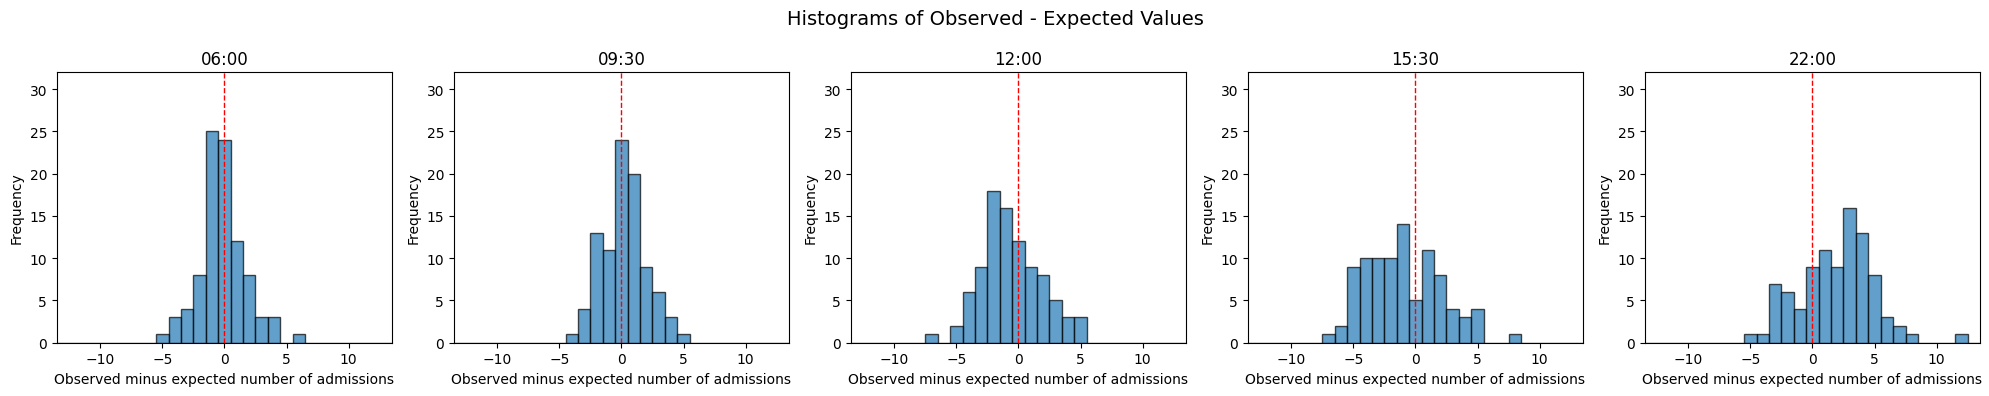

In [17]:
from patientflow.viz.evaluation_plots import plot_observed_against_expected
plot_observed_against_expected(results)

Fro the plots above: 
* The 06:00 data shows a slight positive bias, with most error values indicating that actual admissions were typically higher than predicted.
* The 09:30 data has a similar positive skew but with errors more tightly clustered around 1, confirming its lower MAE.
* The 12:00 distribution appears more spread out with a wider range of errors.
* The 15:30 time slot shows the most balanced distribution around zero, which aligns with its lower MPE.
* The 22:00 time slot displays a distinct positive skew, with most values above zero, suggesting consistent under-prediction (observed values higher than expected).

### QQ (quantile-quantile) Plots

A QQ plot compares a predicted distribution to an observed distribution. In this case, the predicted distribution is the combined set of probability distributions (one for each snapshot date in the test set) at the given prediction time. The observed distribution is derived from the actual number of patients in each group snapshot who were later admitted. 

If the predicted and observed distributions are similar, the qq plot should adhere closely to the y = x line in the plot. 

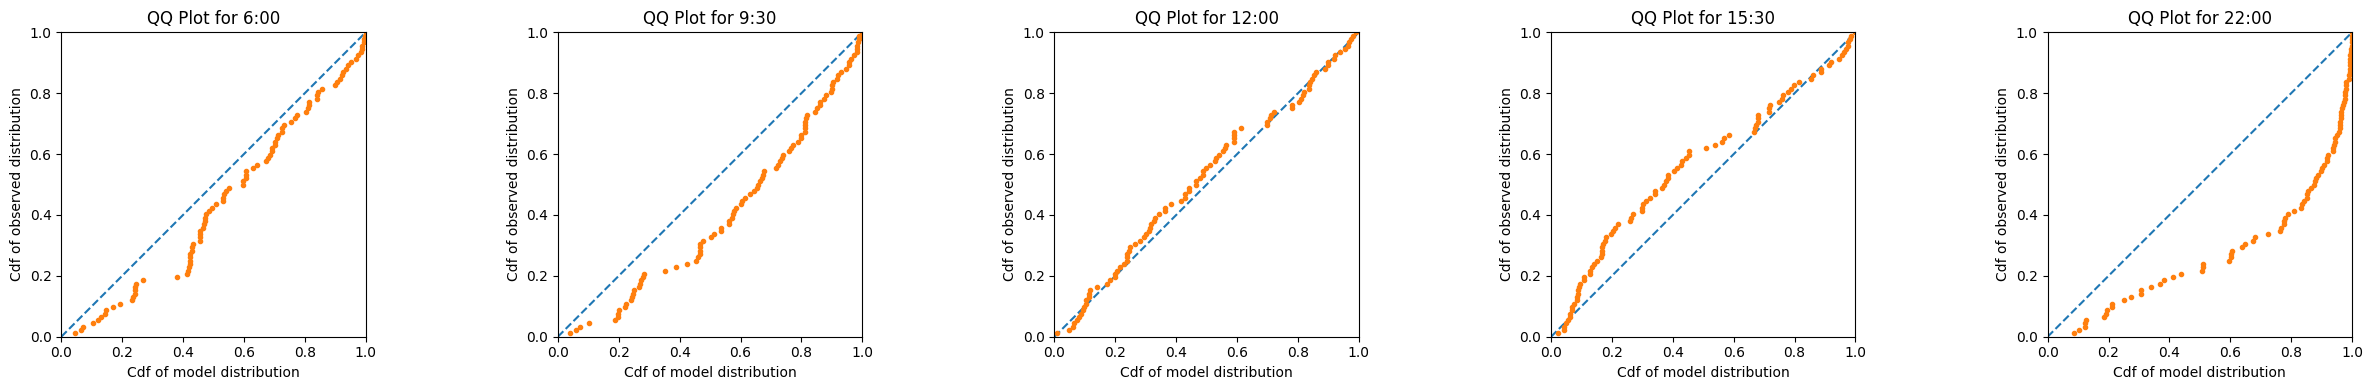

In [18]:
from patientflow.viz.qq_plot import qq_plot

qq_plot(prediction_times, 
        prob_dist_dict_all,
        model_name="admissions")

The 12:00 distributions show the closest adherence to the theoretical distribution (closest to the diagonal line). The 15:30 plot shows reasonable alignment but with some deviation in the lower range. The 06:00 and 09:30 show greater deviations in the middle range, suggesting some bias in predictions, and the 22:00 QQ plot shows significant deviation from the theoretical distribution, with a particularly strong departure in the upper quantiles.

## Conclusions

Here I have demonstrated some methods for evaluating predicted distributions. 

We prefer the QQ plot for evaluating probability distribution predictions for several reasons.

QQ plots directly compare the entire predicted and observed distributions across the full probability range. Unlike summary statistics like MAE or MPE that reduce information to single values, QQ plots preserve and visualise the whole distribution. A comprehensive view can be particularly valuable for detecting issues in the tails of distributions. For instance, in the 22:00 time slot from the UCLH data, the QQ plot reveals deviations in the upper quantiles that summary statistics would obscure.

QQ plots are good for identifying specific types of mismatches — for example whether a model systematically under-predicts high values, over-predicts low values, or misses multimodality in the data. These insights can inform model improvement by showing where and how the predicted distribution fails.
